In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../GlacierLakeDetectionICESat2/GlacierLakeIS2ML/')

import shutil

from IS2ML_utils import *
from figscode import *


In [2]:
# ! cp ../GlacierLakeDetectionICESat2/basins/shapefiles/ANT_basins_merged.* data/shapefiles/
# ! cp ../GlacierLakeDetectionICESat2/basins/shapefiles/Basins_Antarctica_v02.* data/shapefiles/
# ! cp ../GlacierLakeDetectionICESat2/basins/shapefiles/IceShelf_Antarctica_v02.* data/shapefiles/
# ! cp ../GlacierLakeDetectionICESat2/basins/shapefiles/Coastline_Antarctica_v02.* data/shapefiles/
# ! cp ../GlacierLakeDetectionICESat2/FLUID-SuRRF_AIS2019-23_lakestats.csv data/
# ! cp ../GlacierLakeDetectionICESat2/FLUID-SuRRF_AIS2019-23_lakestats_all.csv data/

In [3]:
gdf_basins =  gpd.read_file('data/shapefiles/ANT_basins_merged.shp')
gdf_imbie = gpd.read_file('data/shapefiles/Basins_Antarctica_v02.shp')
gdf_shelf = gpd.read_file('data/shapefiles/IceShelf_Antarctica_v02.shp')
gdf_coast = gpd.read_file('data/shapefiles/Coastline_Antarctica_v02.shp')
gdf_names = pd.concat((gdf_imbie.drop(columns=['Asso_Shelf', 'Subregions']),
                       gdf_shelf)).reset_index(drop=True)

fn_stats = 'data/FLUID-SuRRF_AIS2019-23_lakestats.csv'
df = pd.read_csv(fn_stats)
df['geometry'] = df['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, crs=gdf_basins.crs)

gdf_contours = gpd.read_file('data/shapefiles/ais_contours_rema_500m.shp')
rgt_ais = gpd.read_file('data/shapefiles/rgts_ais_clipped.shp')

# bad lakes, should be fixed now
# to_remove = [
#     'lake_099908_AIS_2018-19_simplified_ANT_1000_West_J-Jpp_ATL03_20190203020131_05590211_006_02_gt1l_0000',
#     'lake_099999_AIS_2021-22_simplified_ANT_1000_West_J-Jpp_ATL03_20220331091725_01261512_006_01_gt1l_0001',
#     'lake_100000_AIS_2022-23_simplified_ANT_1000_West_J-Jpp_ATL03_20230331022530_01481911_006_02_gt1r_0002',
#     'lake_100000_AIS_2018-19_simplified_ANT_1000_East_B-C_ATL03_20190212165420_07060210_006_02_gt2r_0000',
#     'lake_099999_AIS_2018-19_simplified_ANT_1000_West_Ep-F_ATL03_20190117091719_03040211_006_02_gt3l_0005',
#     'lake_100000_AIS_2021-22_simplified_ANT_1000_East_K-A_ATL03_20220101093740_01541412_006_01_gt2r_0001',
#     'lake_099992_AIS_2019-20_simplified_ANT_1000_East_K-A_ATL03_20191104231510_05960512_006_01_gt3l_0017',
#     'lake_099968_AIS_2021-22_simplified_ANT_1000_East_K-A_ATL03_20220318161149_13191410_006_01_gt3l_0000',
#     'lake_099979_AIS_2022-23_simplified_ANT_1000_West_G-H_ATL03_20221213091106_12771710_006_02_gt3r_0003',
# ]
# gdf = gdf[~gdf.lake_id.apply(lambda x: x in to_remove)]

In [4]:
base_dir = '../GLD3_complete/AIS/'
context_dir = 'detection_context/'
imagery_dir = 'detection_imagery/'
data_dir = 'detection_out_data/'
plot_dir = 'detection_out_plot/'

def get_robust_depth(r):
    fn = '%s%s%s/%s.h5' % (base_dir, data_dir, r.label, r.lake_id)
    with h5py.File(fn, 'r') as f:
        if 'depth_data' in f.keys():
            df = pd.DataFrame({k: f['depth_data'][k][()] for k in f['depth_data'].keys()})
            resolution = 5.0
            dfd = df[df.depth>0]
            dfd = dfd[dfd.conf>0.4]
            if len(dfd) > 10:
                return dfd.depth.quantile(0.95)
            else:
                return 0.0
        else:
            return np.nan

if 'rdepth' not in gdf.keys():
    gdf['rdepth'] = gdf.apply(get_robust_depth, axis=1)
    gdf.to_csv(fn_stats)

In [5]:
is_good = (gdf.label=='good_lake') & (~gdf.rdepth.isna())
gdfg = gdf[is_good].copy().reset_index(drop=True)
gdfng = gdf[~is_good].copy().reset_index(drop=True)
gdfg['lid'] = gdfg.apply(lambda x: '_'.join(x.lake_id.split('_')[4:]), axis=1)

In [6]:
from scipy.spatial import cKDTree
k_nearest = 30
quantile = 0.75
maxdist = 1e5 # 100 km
gdfg[['x', 'y']] = gdfg.get_coordinates()
coordinates = gdfg[['x', 'y']].values
kdtree = cKDTree(coordinates)
distances, indices = kdtree.query(coordinates, k=k_nearest)
neighbor_max_depths = gdfg['rdepth'].values[indices]
neighbor_max_depths[distances > maxdist] = np.nan
mean_neighbor_depth = pd.DataFrame(neighbor_max_depths).apply(lambda x: (x[x >= x.quantile(quantile)]).mean(), axis=1)
# mean_neighbor_depth = pd.DataFrame(neighbor_max_depths).quantile(quantile, axis=1)
gdfg['mean_neighbor_depth'] = mean_neighbor_depth

a: I-Ipp, LarsenC > "Larsen C Ice Shelf" (2021-22), -66.27418, -62.72076
b: K-A, Riiser-Larsen > "Riiser-Larsen Ice Shelf" (2019-20), -73.88419, -15.25716
c: A-Ap, Jutulstraumen > "Jutulstraumen Glacier" (2019-20), -70.60809, 6.54447
d: A-Ap, Nivl > "Nivl Ice Shelf" (2019-20), -70.29728, 12.28032
e: A-Ap, Baudouin > "Roi Baudouin Ice Shelf" (2019-20), -70.01645, 32.27773
f: B-C, Amery > "Amery Ice Shelf" (2020-21), -72.94649, 67.85292
g: C-Cp, Tracy_Tremenchus > "Tracy Tremenchus Ice Shelf" (2019-20), -66.06150, 100.33902
h: Dp-E, Tucker > "Tucker Glacier" (2020-21), -72.68862, 169.48888
i: Dp-E, Nansen > "Nansen Ice Shelf" (2020-21), -74.83753, 163.08427
j: E-Ep, Ross_East > "Ross Ice Shelf East (Byrd)" (2020-21), -79.78238, 160.00646
k: E-Ep, Nimrod > "Nimrod Glacier" (2021-22), -82.38758, 161.04365
l: E-Ep, Ross_East > "Ross Ice Shelf East (Scott)" (2018-19), -85.39474, -154.50433
m: Ep-F, Mercer > "Mercer Ice Stream" (2018-19), -85.31501, -146.34351
n: G-H, Pine_Island > "Pine Isla

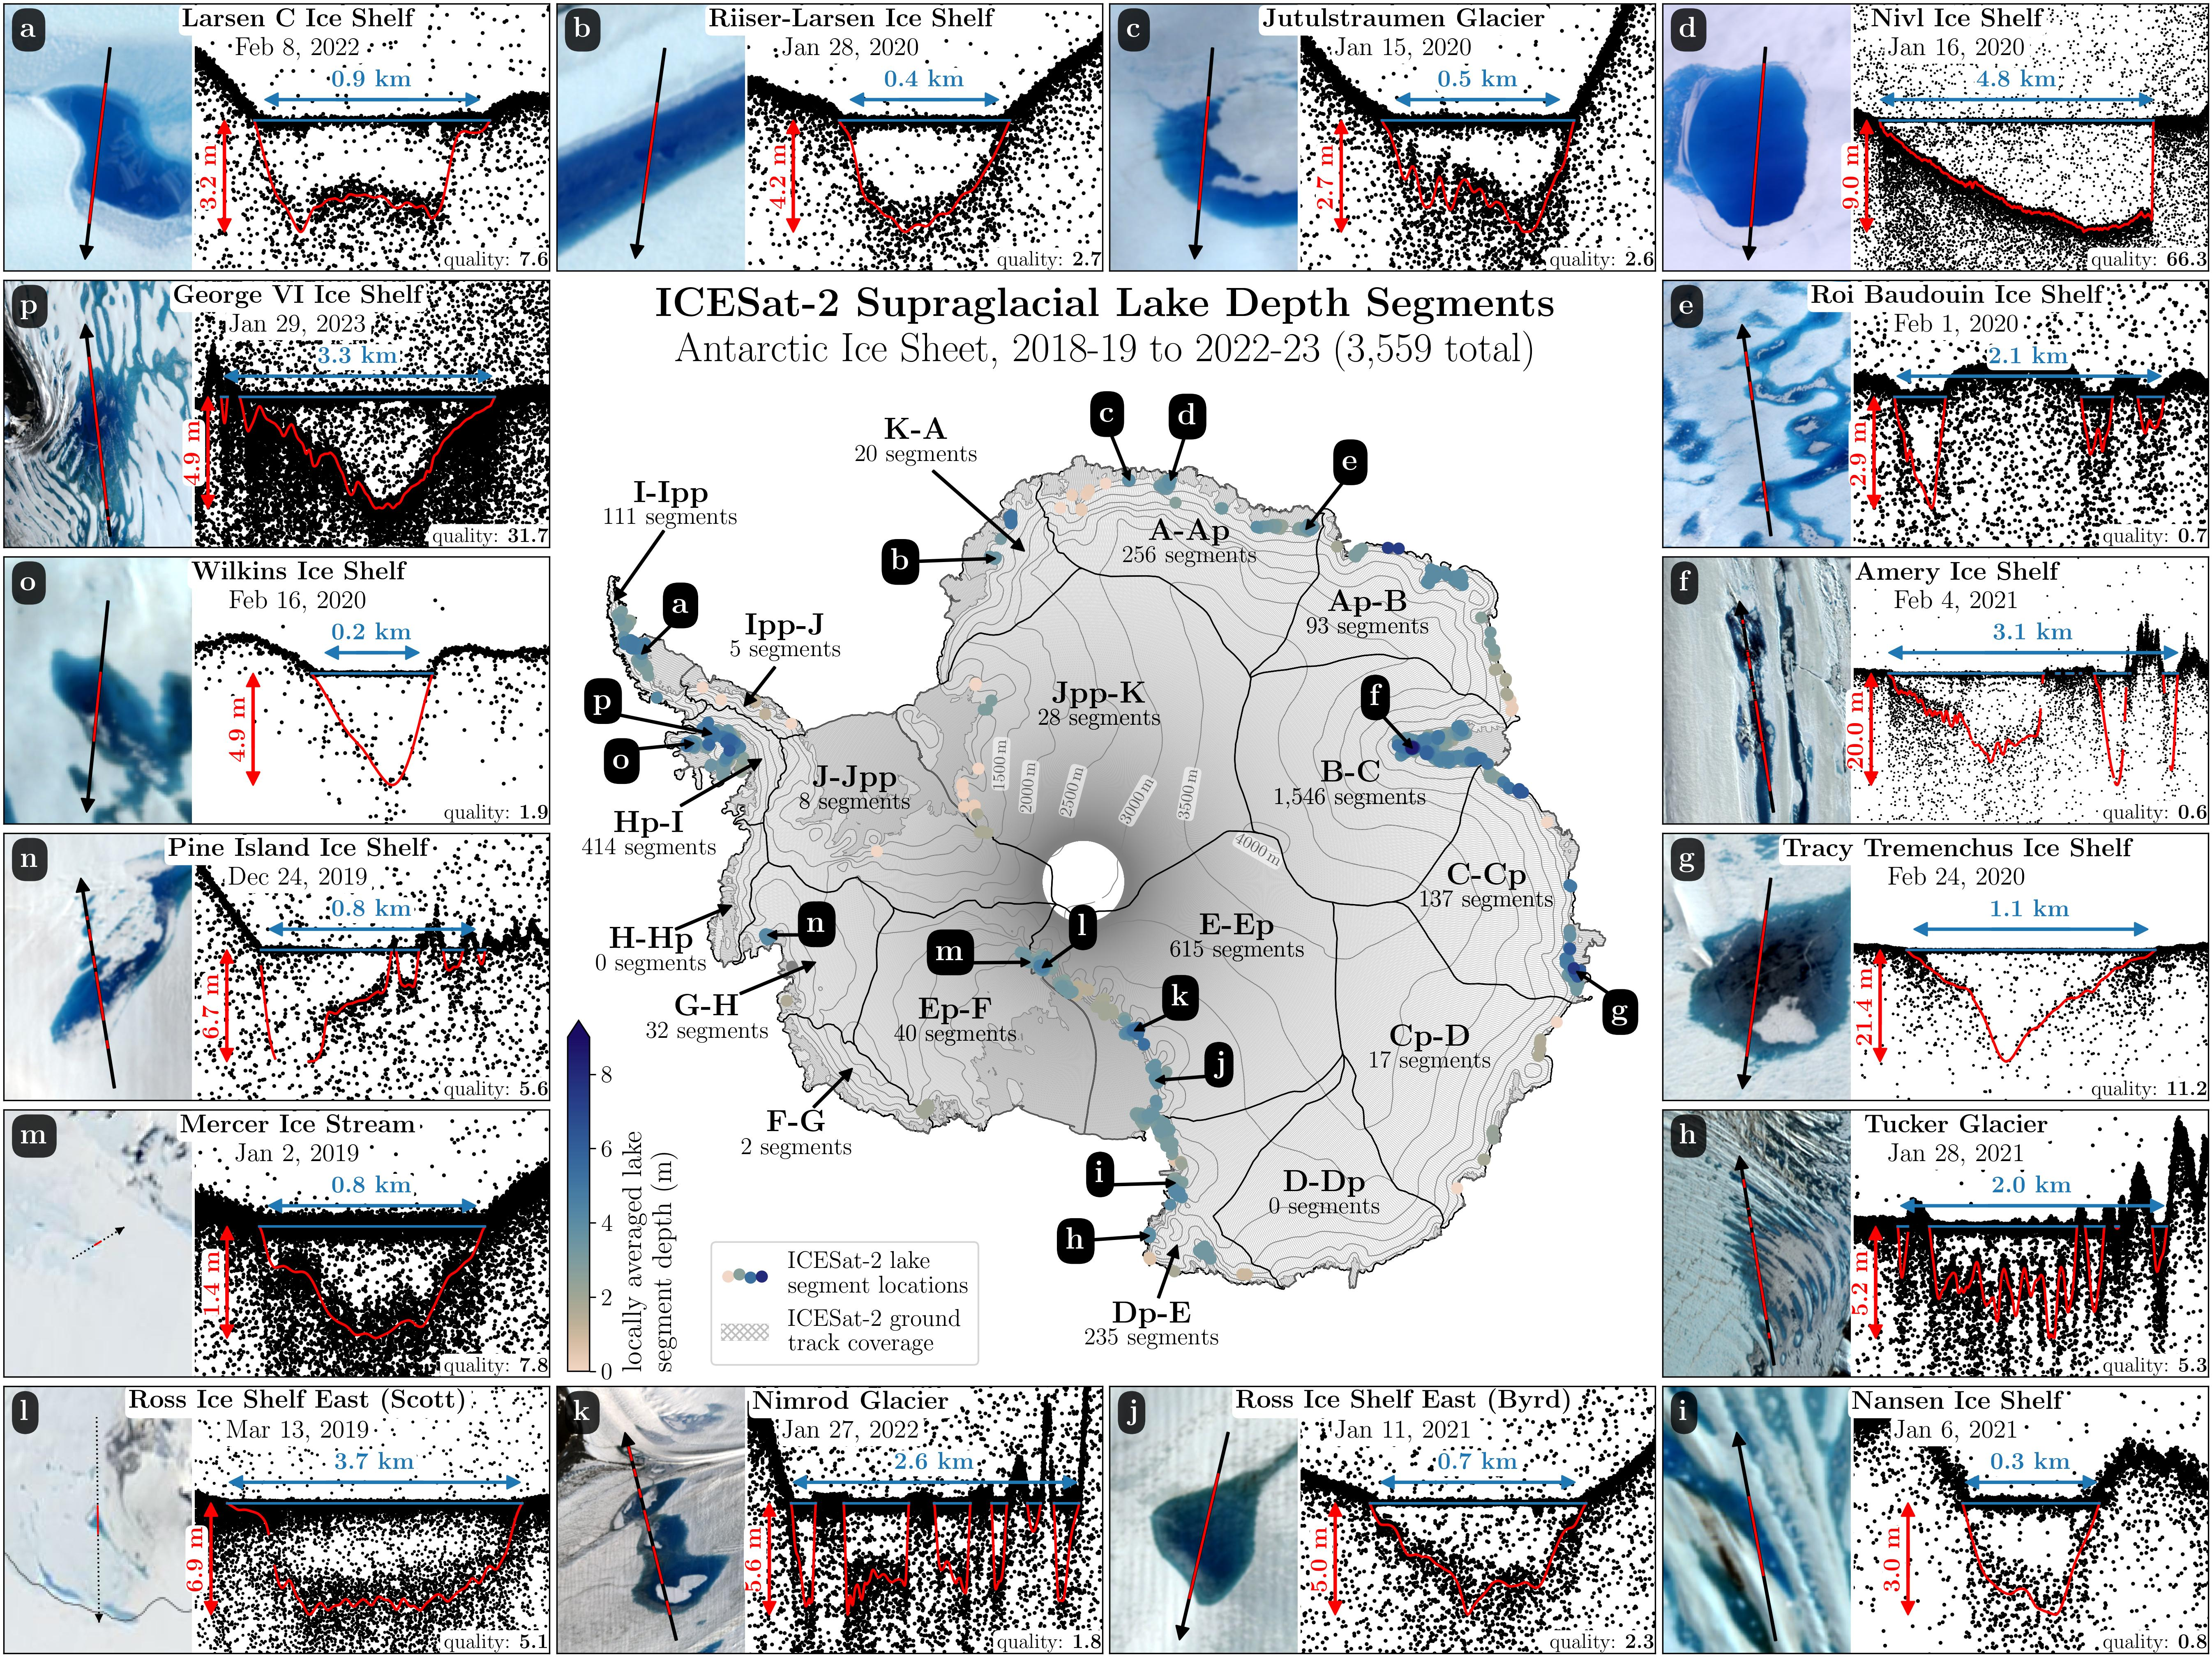

In [7]:
plt.close('all')

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Optima",
    'font.size': 14,
})


figsize = [18, 13.5]
aspect_figure = figsize[1] / figsize[0]
padding = 0.4
adjust_down = 0.11 # for imagery alignment 
layout_parms = {'pad': 0.3, 'h_pad': padding, 'w_pad': padding*aspect_figure}

bdr = 'data/IS2/'
if not os.path.isdir(bdr):
    os.makedirs(bdr)
if not os.path.isdir('data/imagery/'):
    os.makedirs('data/imagery/')
bdr_source = '/Users/parndt/jupyterprojects/GLD3_complete/AIS/detection_out_data/good_lake/'

letterkey = 'd'
pars = {
    # this would be good too, but need Landsat imagery: 'lake_099581_AIS_2020-21_simplified_ANT_1000_Peninsula_I-Ipp_ATL03_20201111190710_07420910_006_01_gt2l_0000.h5'
    'a': [{'fn': 'lake_099198_AIS_2021-22_simplified_ANT_1000_Peninsula_I-Ipp_ATL03_20220208212635_07421410_006_01_gt2l_0000.h5', 'gamma_value': 0.7, 'max_cloud_prob': 50}, {'x': -2119150.123, 'y': 1452840.828},
          {'title': 'Larsen C Ice Shelf'}],
    'b': [{'fn': 'lake_099387_AIS_2019-20_simplified_ANT_1000_East_K-A_ATL03_20200128053234_04960610_006_01_gt2r_0002.h5', 'gamma_value': 0.8}, {'x': -962251.841, 'y': 1681764.032},
          {'title': 'Riiser-Larsen Ice Shelf'}],
    'c': [{'fn': 'lake_099479_AIS_2019-20_simplified_ANT_1000_East_A-Ap_ATL03_20200115044852_02970610_006_01_gt1r_0001.h5', 'gamma_value': 0.7}, {'x': 124901.498, 'y': 2459393.874},
          {'title': 'Jutulstraumen Glacier'}],
    'd': [{'fn': 'lake_097877_AIS_2019-20_simplified_ANT_1000_East_A-Ap_ATL03_20200116042313_03120610_006_01_gt2r_0002.h5', 'gamma_value': 1.0, 'max_cloud_prob': 30, 'source':'landsat'}, {'x': 547476.101, 'y': 2446270.279},
          {'title': 'Nivl Ice Shelf'}],
    'e': [{'fn': 'lake_099905_AIS_2019-20_simplified_ANT_1000_East_A-Ap_ATL03_20200201150322_05630612_006_01_gt2l_0006.h5', 'gamma_value': 0.8}, {'x': 1404131.008, 'y': 2206036.932},
          {'title': 'Roi Baudouin Ice Shelf'}],
    'f': [{'fn': 'lake_099909_AIS_2020-21_simplified_ANT_1000_East_B-C_ATL03_20210204190842_06531012_006_01_gt3r_0007.h5', 'gamma_value': 1.0, 'max_cloud_prob': 30}, {'x': 1535596.722, 'y': 968551.859},
          {'title': 'Amery Ice Shelf'}],
    'g': [{'fn': 'lake_099807_AIS_2019-20_simplified_ANT_1000_East_C-Cp_ATL03_20200224204246_09180610_006_01_gt2r_0005.h5', 'gamma_value': 1.0}, {'x': 2823960.718, 'y': -685813.952},
          {'title': 'Tracy Tremenchus Ice Shelf'}],
    'h': [{'fn': 'lake_099699_AIS_2020-21_simplified_ANT_1000_East_Dp-E_ATL03_20210128124234_05421012_006_01_gt3r_0003.h5', 'gamma_value': 0.7}, {'x': -40453.781, 'y': -1890696.758},
          {'title': 'Tucker Glacier'}], 
    'i': [{'fn': 'lake_099691_AIS_2020-21_simplified_ANT_1000_East_Dp-E_ATL03_20210106141527_02071012_006_01_gt3l_0015.h5', 'gamma_value': 0.7}, {'x': 88155.881, 'y': -1540629.233},
          {'title': 'Nansen Ice Shelf'}],
    'j': [{'fn': 'lake_099507_AIS_2020-21_simplified_ANT_1000_East_E-Ep_ATL03_20210111010129_02751011_006_01_gt2l_0002.h5', 'gamma_value': 0.75}, {'x': 712831.380, 'y': -963198.059},
          {'title': 'Ross Ice Shelf East (Byrd)'}],
    'k': [{'fn': 'lake_099685_AIS_2021-22_simplified_ANT_1000_East_E-Ep_ATL03_20220127202459_05581411_006_01_gt3l_0001.h5', 'gamma_value': 0.8, 'max_cloud_prob': 15}, {'x': 510730.483, 'y': -611489.944},
          {'title': 'Nimrod Glacier'}],
    'l': [{'fn': 'lake_099885_AIS_2018-19_simplified_ANT_1000_West_Ep-F_ATL03_20190313202056_11510211_006_02_gt3l_0004.h5', 'gamma_value': 1.0, 'imagery_filename': 'data/imagery/modis_mercer-scott_2019-01-02.tif'}, {'x': -2552.130, 'y': -240932.708},
          {'title': 'Ross Ice Shelf East (Scott)'}],
    'm': [{'fn': 'lake_099862_AIS_2018-19_simplified_ANT_1000_West_Ep-F_ATL03_20190102075052_00740211_006_02_gt1l_0000.h5', 'gamma_value': 1.0, 'imagery_filename': 'data/imagery/modis_mercer-scott_2019-01-02.tif'}, {'x': -699320.413, 'y': -372088.995},
          {'title': 'Mercer Ice Stream'}],
    'n': [{'fn': 'lake_099512_AIS_2019-20_simplified_ANT_1000_West_G-H_ATL03_20191224015224_13460512_006_01_gt2l_0000.h5', 'gamma_value': 0.8, 'max_cloud_prob': 30}, {'x': -1402661.982, 'y': -224286.055},
          {'title': 'Pine Island Ice Shelf'}],
    'o': [{'fn': 'lake_099651_AIS_2019-20_simplified_ANT_1000_Peninsula_Hp-I_ATL03_20200216082506_07880610_006_01_gt2l_0015.h5', 'gamma_value': 0.8}, {'x': -2428094.550, 'y': 634221.330},
          {'title': 'Wilkins Ice Shelf'}],
    'p': [{'fn': 'lake_099511_AIS_2022-23_simplified_ANT_1000_Peninsula_Hp-I_ATL03_20230129173611_06131812_006_02_gt3r_0075.h5', 'gamma_value': 0.7, 'max_cloud_prob': 30, 'imagery_shift_days': 0}, {'x': -2526693.835, 'y': 949941.776},
          {'title': 'George VI Ice Shelf'}],
}

# if letterkey:
#     pars = {letterkey: pars[letterkey]}

region_locs = {
    'B-C': {'x': 1409197.318, 'y': 492891.791},
    'E-Ep': {'x': 810185.891, 'y': -307613.716},
    'C-Cp': {'x': 2128344.202, 'y': -43966.702},
    'I-Ipp': {'x': -2165163.122, 'y': 1967083.063, 'x_arr': -2466977.918, 'y_arr': 1477436.405, 'arr_frac': 0.1},
    'Dp-E': {'x': 362581.763, 'y': -2348974.696, 'x_arr': 492357.675, 'y_arr': -1912678.611},
    'Ep-F': {'x': -671191.882, 'y': -750521.834},
    'F-G': {'x': -1505915.944, 'y': -1346888.836, 'x_arr': -1216313.545, 'y_arr': -983539.323, 'arr_frac': 0.24},
    'G-H': {'x': -1974645.610, 'y': -736231.057, 'x_arr': -1409601.630, 'y_arr': -424658.415, 'arr_frac': 0.27},
    'H-Hp': {'x': -2270915.409, 'y': -379205.027, 'x_arr': -1851555.623, 'y_arr': -126547.188, 'arr_frac': 0.26},
    'Hp-I': {'x': -2282851.417, 'y': 230414.439, 'x_arr': -1693176.006, 'y_arr': 644148.770, 'arr_frac': 0.25},
    'Ipp-J': {'x': -1565396.912, 'y': 1271066.807, 'x_arr': -1783881.485, 'y_arr': 923787.180},
    'J-Jpp': {'x': -1198890.126, 'y': 469942.548},
    'K-A': {'x': -876662.421, 'y': 2299024.942, 'x_arr': -311618.440, 'y_arr': 1739786.945, 'arr_frac': 0.12},
    'Ap-B': {'x': 1499090.678, 'y': 1393138.789},
    'Jpp-K': {'x': 86480.728, 'y': 911984.127},
}

txt_rot = {x: 0 for x in gdf_basins.Subregions}

# collect the data to pass to plotting functions
for key, lst in pars.items():
    params = lst[0]
    params['fn'] = bdr + params['fn']
    if not os.path.isfile(params['fn']):
        shutil.copyfile(params['fn'].replace(bdr, bdr_source), params['fn'])
        print('copied file')

    lk = dictobj(read_melt_lake_h5(params['fn']))
    if 'imagery_filename' not in params.keys():
        params['imagery_filename'] = ('data/imagery/' + lk.imagery_info['product_id'] + '_' +
                                      params['fn'].split('/')[-1].replace('.h5','') + '.tif' 
                                      if hasattr(lk, 'imagery_info') else None)
    linfo = gdfg[gdfg.lid == lk.lake_id].iloc[0]
    print('%s: %s, %s > "%s" (%s), %.5f, %.5f' % (key, linfo.basin, linfo.sub_basin, lst[2]['title'], linfo.melt_season, linfo.lat, linfo.lon))
    
    params['xlm'] = [None, None]
    params['ylm'] = [None, None]
    # pt_loc = shapely.geometry.Point(lst[1]['x'], lst[1]['y']) if 'x' in lst[1] else gpd.GeoSeries(shapely.geometry.Point(lk.lon, lk.lat), crs='EPSG:4326').to_crs(gdf_basins.crs).iloc[0]
    # lst[1] = find_closest_point(pt_loc, labs_locs)
    lst[2]['date'] = datetime.strftime(datetime.strptime(lk.date_time, '%Y-%m-%dT%H:%M:%SZ'), '%b %-d, %Y')

##########################################
# CREATE FIGURE AND AXES
fig = plt.figure(figsize=figsize, dpi=58)
ny = 6
nx = 4
gs = fig.add_gridspec(ny, nx)
axs = []
axmid = fig.add_subplot(gs[1:ny-1, 1:nx-1])
axmid.axis('off')
ax0 = axmid.inset_axes([0, 0, 1, 0.92])
axtit = axmid.inset_axes([0, 0.92, 1, 0.07])
# del axmid
axtit.axis('off')
axs.append(ax0)
axboxs = []
xs = list(range(nx)) + [nx-1]*(ny-2) + list(range(nx-1,-1,-1)) + [0]*(ny-2)
ys = [0]*nx + list(range(1,ny)) + [ny-1]*(nx-2) + list(range(ny-1,0,-1))
for i in range(len(xs)):
    axboxs.append(fig.add_subplot(gs[ys[i], xs[i]]))
    axboxs[-1].tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)
    axboxs[-1].patch.set_facecolor('none')
    for spine in axboxs[-1].spines.values():
        spine.set_zorder(100)
        
for axbx in axboxs:
    axs.append(axbx.inset_axes([0, 0, 0.345, 1]))
    axs.append(axbx.inset_axes([0.35, 0, 0.65, 1]))

# the map axis
axs[0].axis('off')
# for spine in axs[1].spines.values():
#     spine.set_color('red')

for iax, ax in enumerate(axs[1:]):
    # ax.axis('off')
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, 
               labelbottom=False, labelleft=False)

fig.tight_layout(**layout_parms)

tit = '\\textbf{ICESat-2 Supraglacial Lake Depth Segments}\nAntarctic Ice Sheet, 2018-19 to 2022-23 (%s total)' % "{:,}".format(len(gdfg))
axtit.text(0.5, 0.5, tit, ha='center', va='center', transform=axtit.transAxes, fontsize=24)

# get the optimal imagery axis aspect ratio (axs[1] is the first image axis)
axbx = axs[1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
axis_aspect = axbx.height / axbx.width
print('axis_aspect', axis_aspect)

#############################################
### CENTER MAP
ax = axs[0]
ice_color = '#f1faff'
# gdf_basins.plot(color=ice_color, ax=ax, lw=0.6, zorder=-1, alpha=1)
gdf_basins.boundary.plot(color='black', ax=ax, lw=0.8, zorder=11)
gdf_shelf.plot(ax=ax, color='gray', alpha=0.2)
gdf_shelf.boundary.plot(ax=ax, color='gray', lw=0.4, zorder=12)

gdf_contours.clip(gdf_basins).plot(ax=ax, color='gray', lw=0.5, zorder=9)
rgt_color = 'gray'
rgt_ais.plot(ax=ax, lw=0.2, color=rgt_color, alpha=0.5, zorder=5)
# hdl_rgt, = ax.plot([0,0], [0,0], lw=1, color=rgt_color, alpha=1, label='ICESat-2 ground\ntrack coverage')
hdl_rgt = mpatches.Patch(facecolor="none", hatch='XXXXX', edgecolor=rgt_color, linewidth=0.1, alpha=0.5, label='ICESat-2 ground\ntrack coverage')

xl = ax.get_xlim()
yl = ax.get_ylim()
# xl = (-2581762, 2815603)
# yl = (-2363195, 2460761)
ax.set_xlim(xl)
ax.set_ylim(yl)

markersz = 50
gdfng.plot(ax=ax, markersize=markersz, alpha=1, color='gray', edgecolors='none', linewidth=0, zorder=9)
gdfscatt = gdfg.copy().sort_values(by='mean_neighbor_depth').reset_index(drop=False)
vmin = np.floor(gdfscatt.mean_neighbor_depth.min())
# vmax = np.ceil(gdfscatt.mean_neighbor_depth.max())
vmin = -1
vmax = 9
cmap = cmc.lapaz_r
# cmap = cmc.buda_r
gdfscatt.plot(ax=ax, markersize=markersz, alpha=1, column='mean_neighbor_depth', cmap=cmap, vmin=vmin, vmax=vmax, 
                          edgecolors='none', linewidth=0, zorder=100)
npts = 4
hdl_scatt = ax.scatter([-1e10]*npts, [-1e10]*npts, s=markersz, c=np.linspace(vmin+1,vmax-1,npts), edgecolors='none', linewidth=0, 
                       cmap=cmap, label='ICESat-2 lake\nsegment locations', vmin=vmin, vmax=vmax)

cax = axmid.inset_axes([0.01, 0.005, 0.02, 0.32])
smap = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=9))
smap._A = []
cbar = plt.colorbar(smap, cax=cax, orientation='vertical', extend='max')
cax.set_ylabel('locally averaged lake\nsegment depth (m)', fontsize=16, ha='left')
cax.set_ylim((0, vmax))
cax.yaxis.set_label_coords(2.5, 0.0)

axmid.legend(handles=[hdl_scatt, hdl_rgt], scatterpoints=npts, loc='lower left', bbox_to_anchor=[0.13, 0.0])

# get region counts
region_counts = gdfg.groupby(by='basin')['lake_id'].count().to_dict()
name_sz = plt.rcParams['font.size']+4
count_sz = plt.rcParams['font.size']
annot_color = 'black'

# show basin labels and lake counts
for i in range(len(gdf_basins)):
    x = gdf_basins.iloc[i]
    region = x.Subregions
    lake_count = region_counts[region] if region in region_counts.keys() else 0
    thename = '\\textbf{%s}' % region
    lakequant = 'segment' if lake_count == 1 else 'segments'
    thecount = '%s %s' % ("{:,}".format(lake_count), lakequant)
    if region in region_locs.keys():
        locs = region_locs[region]
        xytext = [locs['x'], locs['y']]
        ax.annotate(text=thename, xy=xytext, ha='center',va='bottom',color=annot_color,fontsize=name_sz, 
                    rotation=txt_rot[region], rotation_mode='anchor', zorder=100)
        ax.annotate(text=thecount, xy=xytext, ha='center',va='top',color=annot_color,fontsize=count_sz, 
                    rotation=txt_rot[region], rotation_mode='anchor', zorder=100)
        if 'x_arr' in locs.keys():
            xyarr = [locs['x_arr'], locs['y_arr']]
            frac = locs['arr_frac'] if 'arr_frac' in locs.keys() else 0.2
            xystart = np.array(xytext) + frac*(np.array(xyarr) - np.array(xytext)) 
            ax.annotate(' ', xy=xyarr, xytext=xystart,ha='center',va='center',color=annot_color,fontsize=count_sz,
                         arrowprops=dict(width=1, headwidth=7, headlength=7, color=annot_color),zorder=1000)
        else:
            ax.annotate(text=thecount, xy=xytext, ha='center',va='top',color=annot_color,fontsize=count_sz, 
                        rotation=txt_rot[region], rotation_mode='anchor', zorder=100)
    else:
        ax.annotate(text=thename, xy=x.geometry.centroid.coords[0], ha='center',va='bottom',
                                           color=annot_color,fontsize=name_sz, weight='bold', zorder=100)
        ax.annotate(text=thecount, xy=x.geometry.centroid.coords[0], ha='center',va='top',
                                           color=annot_color,fontsize=count_sz, zorder=100)

cont_labs = {
    4000: {'x': 920000, 'y': 165152.107, 'rot': -30},
    3500: {'x': 555210.393, 'y': 461600.049, 'rot': 80},
    3000: {'x': 285530.311, 'y': 425826.175, 'rot': 60},
    2500: {'x': -54780.268, 'y': 476526.691, 'rot': 75},
    2000: {'x': -285934.623, 'y': 498374.601, 'rot': 85},
    1500: {'x': -433616.573, 'y': 620039.199, 'rot': 88},
}

for celev in cont_labs.keys():
    txt = '$%.0f\\mathrm{\\,m}$' % celev
    ax.text(cont_labs[celev]['x'], cont_labs[celev]['y'], txt, ha='center', va='center', fontsize=10,
            rotation=cont_labs[celev]['rot'], rotation_mode='anchor', color=[0.35]*3, zorder=10,
           bbox=dict(facecolor='white', alpha=0.6, boxstyle='round,pad=0.07,rounding_size=0.3', lw=0))

fsz_letters = plt.rcParams['font.size']+3
color_letters = 'black'

##########################################
# LAKE PLOTS (ICESat-2 and imagery)
settings = {
    're_download': False,  # to avoid, re-downloading scenes that were already acquired
    'stretch_color': True,  # to stretch the RGB values from their 1st to 99th percentiles
    'img_aspect': axis_aspect,  # adjust to fill max space in the figure
    'increase_linewidth': 1.5,  # for depth data linewidth
    'increase_gtwidth': 1.5,  # for ground track arrow size
    'buffer_factor': 1.4,  # how far the image extent is buffered around the ground track (fraction of ground track bbox)
    'rasterize_scatter': True
}

ax_map = axs[0] 
thesubplots = [[pars[k][0], ik*2+1, pars[k][1], pars[k][2]] for ik, k in enumerate(pars.keys())]

for i_plot,loc in enumerate(thesubplots):
    coords = plot_IS2_imagery(**loc[0], axes=axs[loc[1]:loc[1]+2], **settings)
    plot_coords(coords, ax=ax_map, crs_dst=gdf_basins.crs, text=r'\textbf{%s}' % chr(ord('a')+i_plot), annot_loc=loc[2], color='black')
    add_letter(ax=axs[loc[1]], text=r'\textbf{%s}' % chr(ord('a')+i_plot), fs=fsz_letters, col=color_letters, alpha=0.8)
    if 'modis' not in str(loc[0]['imagery_filename']):
        ax = axs[loc[1]]
        xxl = ax.get_xlim()
        yyl = ax.get_ylim()
        yyr = yyl[1] - yyl[0]
        asp = axis_aspect
        yl = (yyl[0] + adjust_down * yyr, yyl[1])
        ydiff = yl[1] - yl[0]
        xdiff = ydiff/asp
        xl = (np.mean(xxl) - xdiff/2, np.mean(xxl) + xdiff/2)
        ax.set_xlim(xl)
        ax.set_ylim(yl)

bbox_tit = dict(facecolor='white', alpha=1.0, boxstyle='round,pad=0.15,rounding_size=0.25', lw=0)
for i_plot, loc in enumerate(thesubplots):
    ip = int((loc[1]-1)/2)
    axb = axboxs[ip]
    ypos = 0.895
    xpos = 0.54
    txt = '\\textbf{%s}' % loc[3]['title']
    axb.text(xpos, ypos, txt, ha='center', va='bottom', transform=axb.transAxes, fontsize=plt.rcParams['font.size']+1, bbox=bbox_tit, zorder=100)
    txt = loc[3]['date']
    axb.text(xpos, ypos-0.02, txt, ha='center', va='top', transform=axb.transAxes, fontsize=plt.rcParams['font.size']+1, bbox=bbox_tit, zorder=100)

figfn = 'figures/fig01_map-icesat2-segments_ais.jpg'
for savefn in [figfn, figfn.replace('.jpg', '.pdf')]:
    fig.savefig(savefn, dpi=300, bbox_inches='tight', pad_inches=0.03)
fig.savefig(figfn.replace('.jpg','_lowres.jpg'), dpi=60, bbox_inches='tight', pad_inches=0.03)
plt.close(fig)
display(Image(figfn))

# interactive figure for querying label points

using saved modis image
using saved modis image


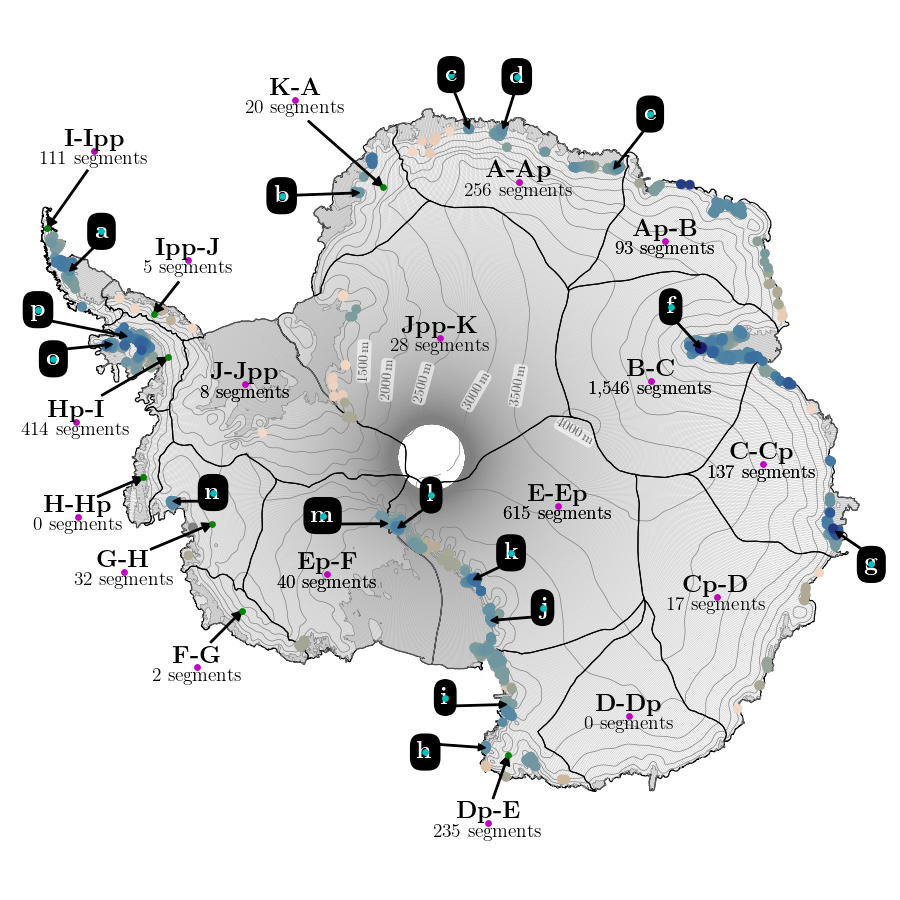

In [169]:
plt.close('all')
fig,ax = plt.subplots(figsize=[figsize[0]/2, figsize[1]*2/3])
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, 
               labelbottom=False, labelleft=False)

ssize = 15
arrcol = 'green'
basincol = 'm'
lettercol = 'c'

gdf_basins.boundary.plot(color='black', ax=ax, lw=0.8, zorder=11)
gdf_shelf.plot(ax=ax, color='gray', alpha=0.2)
gdf_shelf.boundary.plot(ax=ax, color='gray', lw=0.4, zorder=12)

gdf_contours.clip(gdf_basins).plot(ax=ax, color='gray', lw=0.5, zorder=9)
rgt_color = 'gray'
rgt_ais.plot(ax=ax, lw=0.2, color=rgt_color, alpha=0.5, zorder=5)
# hdl_rgt, = ax.plot([0,0], [0,0], lw=1, color=rgt_color, alpha=1, label='ICESat-2 ground\ntrack coverage')
# hdl_rgt = ax.fill_between([-9999, -9998], -9999, -9998, facecolor="none", hatch='XXX', edgecolor=rgt_color, linewidth=0.2, alpha=1, label='ICESat-2 ground\ntrack coverage')
hdl_rgt = mpatches.Patch(facecolor="none", hatch='XXX', edgecolor=rgt_color, linewidth=0.2, alpha=1, label='ICESat-2 ground\ntrack coverage')

xl = ax.get_xlim()
yl = ax.get_ylim()
# xl = (-2581762, 2815603)
# yl = (-2363195, 2460761)
ax.set_xlim(xl)
ax.set_ylim(yl)

markersz = 50
gdfng.plot(ax=ax, markersize=markersz, alpha=1, color='gray', edgecolors='none', linewidth=0, zorder=9)
gdfscatt = gdfg.copy().sort_values(by='mean_neighbor_depth').reset_index(drop=False)
vmin = np.floor(gdfscatt.mean_neighbor_depth.min())
# vmax = np.ceil(gdfscatt.mean_neighbor_depth.max())
vmin = -1
vmax = 9
cmap = cmc.lapaz_r
# cmap = cmc.buda_r
gdfscatt.plot(ax=ax, markersize=markersz, alpha=1, column='mean_neighbor_depth', cmap=cmap, vmin=vmin, vmax=vmax, 
                          edgecolors='none', linewidth=0, zorder=100)
npts = 4
hdl_scatt = ax.scatter([-1e10]*npts, [-1e10]*npts, s=markersz, c=np.linspace(vmin+1,vmax-1,npts), edgecolors='none', linewidth=0, 
                       cmap=cmap, label='ICESat-2 lake\nsegment locations', vmin=vmin, vmax=vmax)

cax = axmid.inset_axes([0.02, 0.02, 0.02, 0.35])
smap = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=9))
smap._A = []
cbar = plt.colorbar(smap, cax=cax, orientation='vertical', extend='max')
cax.set_ylabel('locally averaged lake\nsegment depth (m)', fontsize=16)
cax.set_ylim((0, vmax))

axmid.legend(handles=[hdl_scatt, hdl_rgt], scatterpoints=npts, loc='lower right')

# get region counts
region_counts = gdfg.groupby(by='basin')['lake_id'].count().to_dict()
name_sz = plt.rcParams['font.size']+4
count_sz = plt.rcParams['font.size']
annot_color = 'black'

# show basin labels and lake counts
for i in range(len(gdf_basins)):
    x = gdf_basins.iloc[i]
    region = x.Subregions
    lake_count = region_counts[region] if region in region_counts.keys() else 0
    thename = '\\textbf{%s}' % region
    lakequant = 'segment' if lake_count == 1 else 'segments'
    thecount = '%s %s' % ("{:,}".format(lake_count), lakequant)
    if region in region_locs.keys():
        locs = region_locs[region]
        xytext = [locs['x'], locs['y']]
        if 'x_arr' in locs.keys():
            bbx_label = dict(facecolor='white', alpha=1, edgecolor='none', boxstyle="Round, pad=0.1")
        else:
            bbx_label = None
        ax.annotate(text=thename, xy=xytext, ha='center',va='bottom',color=annot_color,fontsize=name_sz, 
                    rotation=txt_rot[region], rotation_mode='anchor', zorder=2000)
        ax.annotate(text=thecount, xy=xytext, ha='center',va='top',color=annot_color,fontsize=count_sz, 
                    rotation=txt_rot[region], rotation_mode='anchor', zorder=2000)
        ax.scatter(locs['x'], locs['y'], s=ssize, color=basincol, zorder=1000)
        if 'x_arr' in locs.keys():
            xyarr = [locs['x_arr'], locs['y_arr']]
            frac = locs['arr_frac'] if 'arr_frac' in locs.keys() else 0.2
            xystart = np.array(xytext) + frac*(np.array(xyarr) - np.array(xytext)) 
            ax.annotate(' ', xy=xyarr, xytext=xystart,ha='center',va='center',color=annot_color,fontsize=count_sz,
                         arrowprops=dict(width=1, headwidth=7, headlength=7, color=annot_color),zorder=1000)
            ax.scatter(locs['x_arr'], locs['y_arr'], s=ssize, color=arrcol, zorder=1000)
        else:
            ax.annotate(text=thecount, xy=xytext, ha='center',va='top',color=annot_color,fontsize=count_sz, 
                        rotation=txt_rot[region], rotation_mode='anchor', zorder=2000)
    else:
        ax.annotate(text=thename, xy=x.geometry.centroid.coords[0], ha='center',va='bottom',
                                           color=annot_color,fontsize=name_sz, weight='bold', zorder=100)
        ax.annotate(text=thecount, xy=x.geometry.centroid.coords[0], ha='center',va='top',
                                           color=annot_color,fontsize=count_sz, zorder=100)
        ax.scatter(x.geometry.centroid.coords[0][0], x.geometry.centroid.coords[0][1], s=ssize, color=basincol, zorder=1000)

cont_labs = {
    4000: {'x': 920000, 'y': 165152.107, 'rot': -30},
    3500: {'x': 555210.393, 'y': 461600.049, 'rot': 80},
    3000: {'x': 285530.311, 'y': 425826.175, 'rot': 60},
    2500: {'x': -54780.268, 'y': 476526.691, 'rot': 75},
    2000: {'x': -285934.623, 'y': 498374.601, 'rot': 85},
    1500: {'x': -433616.573, 'y': 620039.199, 'rot': 88},
}

for celev in cont_labs.keys():
    txt = '$%.0f\\mathrm{\\,m}$' % celev
    ax.text(cont_labs[celev]['x'], cont_labs[celev]['y'], txt, ha='center', va='center', fontsize=10,
            rotation=cont_labs[celev]['rot'], rotation_mode='anchor', color=[0.35]*3, zorder=10,
           bbox=dict(facecolor='white', alpha=0.6, boxstyle='round,pad=0.07,rounding_size=0.3', lw=0))

fsz_letters = plt.rcParams['font.size']+3
color_letters = 'black'

##########################################
# LAKE PLOTS (ICESat-2 and imagery)
settings = {
    're_download': False,  # to avoid, re-downloading scenes that were already acquired
    'stretch_color': True,  # to stretch the RGB values from their 1st to 99th percentiles
    'img_aspect': axis_aspect,  # adjust to fill max space in the figure
    'increase_linewidth': 1.5,  # for depth data linewidth
    'increase_gtwidth': 1.5,  # for ground track arrow size
    'buffer_factor': 1.4,  # how far the image extent is buffered around the ground track (fraction of ground track bbox)
    'rasterize_scatter': True
}

ax_map = axs[0] 
thesubplots = [[pars[k][0], ik*2+1, pars[k][1], pars[k][2]] for ik, k in enumerate(pars.keys())]

fig2, axs = plt.subplots(ncols=2)

for i_plot,loc in enumerate(thesubplots):
    coords = plot_IS2_imagery(**loc[0], axes=list(axs), **settings)
    plot_coords(coords, ax=ax, crs_dst=gdf_basins.crs, text=r'\textbf{%s}' % chr(ord('a')+i_plot), annot_loc=loc[2], color=color_letters)
    add_letter(ax=axs[0], text=r'\textbf{%s}' % chr(ord('a')+i_plot), fs=fsz_letters, col=color_letters, alpha=0.5)
    ax.scatter(loc[2]['x'], loc[2]['y'], s=ssize, color=lettercol, zorder=100000) 

bbox_tit = dict(facecolor='white', alpha=1.0, boxstyle='round,pad=0.15,rounding_size=0.25', lw=0)
for i_plot, loc in enumerate(thesubplots):
    ip = int((loc[1]-1)/2)
    axb = axboxs[ip]
    ypos = 0.895
    xpos = 0.54
    txt = '\\textbf{%s}' % loc[3]['title']
    axb.text(xpos, ypos, txt, ha='center', va='bottom', transform=axb.transAxes, fontsize=plt.rcParams['font.size']+1, bbox=bbox_tit, zorder=100)
    txt = loc[3]['date']
    axb.text(xpos, ypos-0.02, txt, ha='center', va='top', transform=axb.transAxes, fontsize=plt.rcParams['font.size']+1, bbox=bbox_tit, zorder=100)

plt.close(fig2)

fig.tight_layout(pad=0)

# to get coordinates from clicks
coords = []
def onclick(event):
    global ix, iy
    ix, iy = event.xdata, event.ydata
    print("'x': %.3f, 'y': %.3f" % (ix,iy))
    global coords
    coords.append((ix,iy))
    if len(coords) > 100:
        fig.canvas.mpl_disconnect(cid)
    return coords
cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [168]:
# print the last clicked point
print("\n{'x': %.3f, 'y': %.3f}\n" % (coords[-1][0], coords[-1][1]))
print("\n{'x_arr': %.3f, 'y_arr': %.3f}\n" % (coords[-1][0], coords[-1][1]))


{'x': 86480.728, 'y': 911984.127}


{'x_arr': 86480.728, 'y_arr': 911984.127}



In [167]:
cont_labs = {
    4000: {'x': 920000, 'y': 165152.107, 'rot': -30},
    3500: {'x': 555210.393, 'y': 461600.049, 'rot': 80},
    3000: {'x': 285530.311, 'y': 425826.175, 'rot': 60},
    2500: {'x': -54780.268, 'y': 476526.691, 'rot': 75},
    2000: {'x': -285934.623, 'y': 498374.601, 'rot': 85},
    1500: {'x': -433616.573, 'y': 620039.199, 'rot': 88},
}

for celev in cont_labs.keys():
    txt = '$%.0f\\mathrm{\\,m}$' % celev
    ax.text(cont_labs[celev]['x'], cont_labs[celev]['y'], txt, ha='center', va='center', fontsize=10,
            rotation=cont_labs[celev]['rot'], rotation_mode='anchor', color=[0.35]*3, zorder=10,
           bbox=dict(facecolor='white', alpha=0.6, boxstyle='round,pad=0.07,rounding_size=0.3', lw=0))

In [183]:
! cp ../GlacierLakeDetectionICESat2/basins/shapefiles/GroundingLine_Antarctica_v02.* data/shapefiles/

In [173]:
gdf_basins_thresh = gpd.read_file('data/shapefiles/ANT_basins_thresh1000.shp')

x          y
0  -127.179810 -73.611580
0  -127.165314 -73.606186
0  -127.165985 -73.598969
0  -127.232758 -73.584648
0  -127.255875 -73.583931
..         ...        ...
0   -63.853367 -68.887434
0   -63.832983 -68.902392
0   -63.800806 -68.896691
0   -63.788622 -68.894530
0   -63.821703 -68.890470

[39067 rows x 2 columns]

In [182]:
latmin = gdf.lat.min()
latmax = gdf.lat.max()
print('Lakes were found from %.1f°S to %.1f°S.' % (latmax, latmin))

gdf_basins_thresh = gpd.read_file('data/shapefiles/ANT_basins_thresh1000.shp')
coords = gdf_basins_thresh.dissolve().to_crs('EPSG:4326').get_coordinates()
latmin_basins = coords.y.min()
latmax_basins = coords.y.max()
print('The study area extends from %.1f°S to %.1f°S.' % (latmax_basins, latmin_basins))

# this is full track spacing, tracks next to each other should only be ascending or descending...
# code for this disappeared somewhere will fix later, numbers are in paper
# ^ eh, can solve the above by dividing by 2!
# also need to account for angle actually??
from shapely.geometry import Point, LineString
rgt_ais = gpd.read_file('data/shapefiles/rgts_polar_south.shp').to_crs(gdf_basins.crs)

def lon_diff_to_meters(lon_diff, latitude):
    R = 6378137 # Radius of the Earth in meters
    lat_rad = math.radians(latitude)
    lon_diff_rad = math.radians(lon_diff)
    distance_meters = R * lon_diff_rad * math.cos(lat_rad)
    return abs(distance_meters)

print(' ')
lons = np.arange(-180, 180, 0.01)
for lat in [-70, latmin_basins, latmin, latmax, latmax_basins]:
    lats = np.ones_like(lons)*lat
    df = pd.DataFrame({'lon': lons, 'lat': lats})
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326").to_crs(rgt_ais.crs)
    parall = LineString(gdf.geometry.tolist())
    rgt_int = rgt_ais[rgt_ais.intersects(parall)].copy()
    pts = rgt_int.intersection(parall)
    ptslatlon = pts.to_crs('EPSG:4326').get_coordinates()
    ptsll = gpd.GeoDataFrame(ptslatlon, geometry=pts, crs=rgt_ais.crs).sort_values(by='x').reset_index(names='idx')
    spacing = lon_diff_to_meters(ptsll.x.diff().mean(), latitude=lat)*2.0
    print('The ICESat-2 track spacing is about %.1f km at %g degrees latitude.' % (spacing/1000, lat))

Lakes were found from -63.2°S to -63.2°S.
The study area extends from -63.2°S to -86.1°S.
 
The ICESat-2 track spacing is about 9.9 km at -70 degrees latitude.
The ICESat-2 track spacing is about 2.0 km at -86.0731 degrees latitude.
The ICESat-2 track spacing is about 13.0 km at -63.2129 degrees latitude.
The ICESat-2 track spacing is about 13.0 km at -63.2129 degrees latitude.
The ICESat-2 track spacing is about 13.0 km at -63.2129 degrees latitude.


In [ ]:
ax_ratio = 6409/6538
ax_wid = 10
fig, ax = plt.subplots(figsize=[ax_wid, ax_wid*ax_ratio], dpi=80)
ax.axis('off')
fig.tight_layout()

ice_color = '#f1faff'
gdf_basins.plot(color=ice_color, ax=ax, lw=0.6, zorder=-1, alpha=1)
gdf_basins.boundary.plot(color='black', ax=ax, lw=0.8, zorder=11)
gdf_shelf.plot(ax=ax, color='blue', alpha=0.1)
gdf_shelf.boundary.plot(ax=ax, color='blue', lw=0.4, zorder=12)

xl = (-2581762, 2815603)
yl = (-2363195, 2460761)
ax.set_xlim(xl)
ax.set_ylim(yl)

#gdf_fp.plot(ax=ax, markersize=7, alpha=1, color='m', edgecolors='none', linewidth=0, zorder=8)
gdfng.plot(ax=ax, markersize=15, alpha=1, color='gray', edgecolors='none', linewidth=0, zorder=9)
# gdfg.plot(ax=ax, markersize=30, alpha=1, color='red', edgecolors='none', linewidth=0, zorder=10)

gdfscatt = gdfg.copy().sort_values(by='mean_neighbor_depth').reset_index(drop=False)
vmin = np.floor(gdfscatt.mean_neighbor_depth.min())
vmax = np.ceil(gdfscatt.mean_neighbor_depth.max())
cmap = cmc.lapaz_r
cmap = cmc.buda_r
gdfscatt.plot(ax=ax, markersize=30, alpha=1, column='mean_neighbor_depth', cmap=cmap, vmin=vmin, vmax=vmax, 
                          edgecolors='none', linewidth=0, zorder=10)
npts = 4
hdl_scatt = ax.scatter([-1e10]*npts, [-1e10]*npts, s=30, c=np.linspace(vmin+3,vmax-1,npts), edgecolors='none', linewidth=0, 
                       cmap=cmap, label='ICESat-2 lake\nsegment locations', vmin=vmin, vmax=vmax)

# gdfscatt.plot(ax=ax, markersize=30, alpha=1, column='mean_neighbor_depth', cmap=cmap, vmin=vmin, vmax=vmax, 
#                           edgecolors='none', linewidth=0, zorder=9)

# to get coordinates from clicks
coords = []
def onclick(event):
    global ix, iy
    ix, iy = event.xdata, event.ydata
    print("'x': %.3f, 'y': %.3f" % (ix,iy))
    global coords
    coords.append((ix,iy))
    if len(coords) > 100:
        fig.canvas.mpl_disconnect(cid)
    return coords
cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [ ]:
axxl = ax.get_xlim()
axyl = ax.get_ylim()
xvls = [axxl[i] for i in [0,1,1,0,0]]
yvls = [axyl[i] for i in [0,0,1,1,0]]
poly = Polygon(list(zip(xvls,yvls)))

gdfgg = gdfg[gdfg.geometry.within(poly)]

gdfg_sort = gdfgg.sort_values(by='depth_quality_sort', ascending=False)
# gdfg_sort = gdfgg.sort_values(by='rdepth', ascending=False)
# gdfg_sort = gdfgg.sort_values(by='lat', ascending=True)

# gdfg_sort = gdfgg.sort_values(by='max_depth', ascending=False)
# gdfg_sort = gdfgg.sort_values(by='depth_mean', ascending=False)
# gdfg_sort = gdfgg.sort_values(by='depth_median', ascending=False)
# gdfg_sort = gdfgg.sort_values(by='surface_elevation', ascending=False)
# gdfg_sort = gdfgg.sort_values(by='conf_median', ascending=False)
# gdfg_sort = gdfgg.sort_values(by='conf_mean', ascending=False)
# gdfg_sort = gdfgg.sort_values(by='conf_q90', ascending=False)
# gdfg_sort = gdfgg.sort_values(by='length_water', ascending=False)
# gdfg_sort = gdfgg.sort_values(by='total_length', ascending=False)
# gdfg_sort = gdfgg.sort_values(by='ratio_water', ascending=False)


base_dir = '/Users/parndt/jupyterprojects/GLD3_complete/AIS/'
img_dir = 'detection_context/'
data_dir = 'detection_out_data/'

start = 0
n_imgs = 20
for i in np.arange(start, start+n_imgs):
    if i<len(gdfg_sort):
        r = gdfg_sort.iloc[i]
        data_path = '%s%s%s/%s.h5' % (base_dir, data_dir, r.label, r.lake_id)
        img_path = '%s%s%s/%s_context.jpg' % (base_dir, img_dir, r.label, r.lake_id)
        print("\n%02i: '%s' %s, %s, %s, %s, %s\n'%s.h5'," % (i+1, r.label, r.basin, r.melt_season, r.sub_basin, r.rdepth, r.mean_neighbor_depth, r.lake_id))
        display(Image(img_path))

In [ ]:
basedir = '/Volumes/nox2/phil/IceLakesRun2/upto21jun2023_data/'
fn = 'lake_09996401_AIS_2019-20_simplified_ANT_1000_East_C-Cp_ATL03_20200224204246_09180610_006_01_gt2r_0002.h5'
lkpath = basedir+fn
lk = dictobj(read_melt_lake_h5(lkpath))
dfd = lk.depth_data
df = lk.photon_data
fig,ax = plt.subplots()
ax.scatter(df.xatc, df.h, s=1, color='k', edgecolors='none')
ax.plot(dfd.xatc, dfd.h_fit_bed, 'r-')

In [ ]:
convert_time_to_string(lk.mframe_data.dt.mean())

## for generating contour lines from REMA

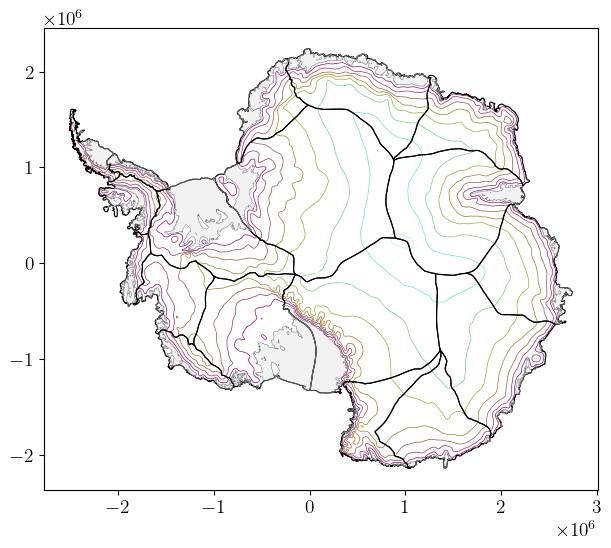

In [29]:
import rasterio
from rasterio.windows import from_bounds
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from shapely.geometry import LineString, mapping, MultiLineString
import fiona
from fiona.crs import from_epsg

# Open the DEM file
with rasterio.open('data/REMA/rema_mosaic_1km_v2.0_filled_cop30_dem.tif') as src:
    crs_dem = src.crs
    data = src.read(1)
    window_transform = src.transform
    x = np.arange(data.shape[1])
    y = np.arange(data.shape[0])
    x, y = np.meshgrid(x, y)
    x, y = rasterio.transform.xy(window_transform, y, x, offset='center')
    
x = np.array(x)
y = np.array(y)

data_smooth = gaussian_filter(data, sigma=15)
# data_smooth = data

# Step 5: Generate contour lines
fig, ax = plt.subplots()
contour_levels = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500] 
contours = ax.contour(x, y, data_smooth, levels=contour_levels)
plt.close(fig)

# Initialize a list to hold dictionaries with 'geometry' and 'level' keys
contour_data = []

# Iterate over each contour collection and group lines by level
for level, collection in zip(contour_levels, contours.collections):
    lines = []
    for path in collection.get_paths():
        v = path.vertices
        line = LineString(v)
        lines.append(line)
    
    # Create a MultiLineString for this contour level and add to the data list
    if lines:
        multiline = MultiLineString(lines)
        contour_data.append({'elevation': level, 'geometry': multiline})

# Convert the list of dictionaries to a GeoDataFrame
gdf_contours = gpd.GeoDataFrame(contour_data, crs=crs_dem)

fig, ax = plt.subplots(figsize=[8,6])
gdf_basins.boundary.plot(color='black', ax=ax, lw=0.8, zorder=11)
gdf_shelf.plot(ax=ax, color='gray', alpha=0.1)
gdf_shelf.boundary.plot(ax=ax, color='gray', lw=0.4, zorder=12)
gdf_contours.clip(gdf_basins).plot(ax=ax, column='elevation', cmap=cmc.hawaii, lw=0.5)
plt.close(fig)
display(fig)

gdf_contours.to_file('data/shapefiles/ais_contours_rema_500m.shp')

## for getting the RGT shapefile 
the KML data need to be downloaded from the technical specs site for ICESat-2

cycle 12 was RGT-pointing, so this one is used here

number *.kml: 1387
RGT 1387 / 1387
--> done.


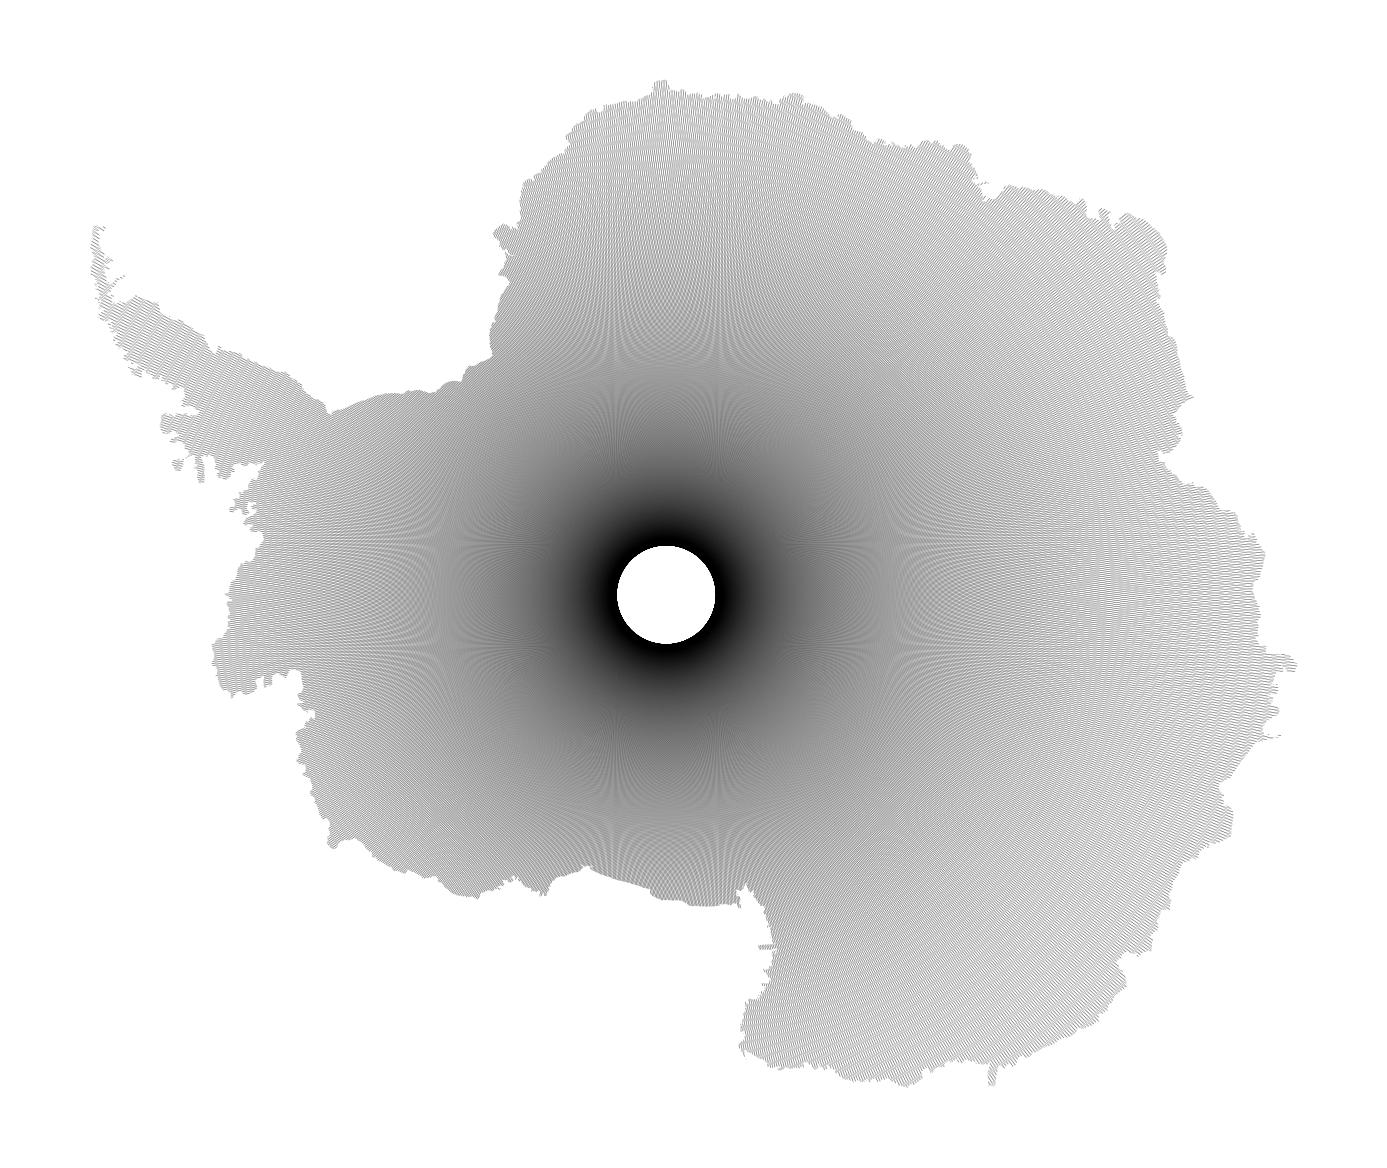

In [45]:
import fiona
fiona.drvsupport.supported_drivers['libkml'] = 'rw' 
fiona.drvsupport.supported_drivers['LIBKML'] = 'rw'

searchdir = '../greenland-supraglacial-lake-depths-figures/data/shapefiles/zzz_kmls/cycle12kmls/IS2_RGTs_cycle12_date_time/'
searchfor = '.kml'
filelist = [searchdir+f for f in os.listdir(searchdir) \
            if os.path.isfile(os.path.join(searchdir, f)) & (searchfor in f)]
filelist.sort()
listlength = len(filelist)
print('number *%s:' % searchfor, listlength)

gdfs_kml = []
for fn_kml in filelist:
    gdf_kml = gpd.read_file(fn_kml)[['Name', 'geometry']]
    print('%8s / %4i' % (gdf_kml.Name.iloc[0], listlength), end='\r')
    gdfs_kml.append(gdf_kml)
gdf_kmls = pd.concat(gdfs_kml)
print('\n--> done.')

gdf_kmls['rgt'] = gdf_kmls.Name.apply(lambda x: int(x.split(' ')[-1]))
gdf_kmls = gdf_kmls.set_index('rgt', drop=True)
bounds_ant = gdf_basins.buffer(1e6).total_bounds
bbox = Polygon([(bounds_ant[i], bounds_ant[j]) for i, j in [(0,1), (2,1), (2,3), (0,3), (0,1)]])
rgt_antarctica = gdf_kmls.to_crs(gdf_basins.crs)
rgt_ais = rgt_antarctica.clip(bbox)
rgt_ais.to_file('data/shapefiles/rgts_polar_south.shp')
rgt_ais.clip(gdf_basins).to_file('data/shapefiles/rgts_ais_clipped.shp')

rgt_ais = gpd.read_file('data/shapefiles/rgts_ais_clipped.shp')
fig,ax = plt.subplots(dpi=300)
rgt_ais.plot(ax=ax, color='k', lw=0.1, alpha=0.5)
ax.axis('off')
plt.close(fig)
display(fig)